### Project 03 - Classify Alpaca, Camel, Dog
Leonard Hübner
Herbert Grünsteidl
Ivan Birkmaier

#### Imports

In [1]:
import os

import IPython.display as display
import fiftyone as fo
import fiftyone.zoo as foz
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from fiftyone import ViewField as F
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [2]:
print(tf.keras.__version__)
print(tf.__version__)

2.10.0
2.10.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Script Variables

In [4]:
# Data genration
__file__ = 'computer_vision_group-3.ipynb'
my_classes = ["Alpaca", "Camel", "Dog"]
folder = 'DataNew'

script_dir = os.path.dirname(os.path.abspath(__file__))

base_export_dir = f"{script_dir}/{folder}"
print(base_export_dir)

# Data split
max_samples = 1000
train_split = 0.8
min_resolution = 224

# Model 
num_classes = len(my_classes)
l2_regularizer_rate = 0.01
target_size=(224, 224)

C:\Users\Leo\Documents\Master AI\SS 24\Computer Vision\CNN_Project/DataNew


### Task: Generation of Dataset (with Data-Split)

- Preparation: Split dataset into a 80/20 Train/test split

Erstellt einen Datensatz:

In [5]:
# for animal_class in my_classes:
# 
#     print(f"start loading of {animal_class}")
# 
#     # Load dataset
#     dataset = foz.load_zoo_dataset(
#         "open-images-v7",
#         dataset_name = f"{animal_class}_{max_samples}",
#         split="train",
#         label_types=["detections"],
#         classes= [animal_class],
#         max_samples=max_samples,
#         shuffle=True
#     )
# 
#     # Filter the dataset to only include specified classes
#     dataset = dataset.filter_labels("ground_truth", F("label").is_in(animal_class))
# 
#     patches = dataset.to_patches("ground_truth")
#     # patches = patches.filter_labels("ground_truth", F("bounding_box")[2] * dataset.metadata.total_width >= min_resolution)
#     # patches = patches.filter_labels("ground_truth", F("bounding_box")[3] * dataset.metadata.total_height >= min_resolution)
# 
#     # Splitting the dataset into train and test subsets
#     train_patches = patches.take(np.floor(train_split * len(patches)), seed=42)  # 80% of the data for training
#     train_ids = train_patches.values("id")
#     test_patches = patches.exclude(train_ids)  # The rest for testing
# 
#     print(f"\n {animal_class} Train/Test-Split:")
#     print(f"train: {len(train_patches)/len(patches)*100}%")
#     print(f"test: {len(test_patches)/len(patches)*100}%\n")
# 
# 
#     # Export train dataset
#     train_export_dir = f"{base_export_dir}/train"
#     train_patches.export(
#         export_dir=train_export_dir,
#         dataset_type=fo.types.ImageClassificationDirectoryTree,
#         label_field="ground_truth",
#     )
# 
#     # Export test dataset
#     test_export_dir = f"{base_export_dir}/test"
#     test_patches.export(
#         export_dir=test_export_dir,
#         dataset_type=fo.types.ImageClassificationDirectoryTree,
#         label_field="ground_truth",
#     )


### Task: Activation Map (The Grad-CAM algorithm)

In [6]:
# Activation Map Quelle: https://keras.io/examples/vision/grad_cam/

def get_img_array(img_path, size):
    # PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # array is a Numpy array with a data type of float32 and dimensions of 299x299x3.
    array = keras.utils.img_to_array(img)
    # To convert our array into a "batch" format, we introduce an additional dimension, resulting in a shape of (1, 299, 299, 3).
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, construct a model that links the input image both to the activations of the final convolutional layer and to the output predictions.
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, calculate the gradient of the highest predicted class for our input image relative to the activations of the final convolutional layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This represents the gradient of the output neuron (either the top predicted or selected) with respect to the output feature map of the last convolutional layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This vector consists of entries, each representing the average intensity of the gradient across a particular channel of the feature map.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # scale each channel in the feature map array by its importance relative to the top predicted class, then aggregate all the channels to generate the class activation heatmap.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, normalize the heatmap to fall within the range of 0 to 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale the heatmap to fall within the 0-255 range
    heatmap = np.uint8(255 * heatmap)

    # colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Apply RGB values from the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Generate an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Overlay the heatmap onto the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Store the superimposed image
    superimposed_img.save(cam_path)

    # Show the Grad-CAM visualization
    display(Image(cam_path))

### Task: Experiment transfer learning

- Use a imagenet pretrained VGG19 architecture, train the model and estimate the testset accurac

Schritt 1: Laden vortrainiertes VGG19 Models (mit imagenet)

In [8]:
# vortrainiertes Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Schritt 2: Defintion des Models (Layer Aktivierungsfunktion)

In [9]:
# Feature-Extraktion
x = base_model.output

# Klassifizierungslayer hinzufügen
x = GlobalMaxPooling2D()(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

# Modell zusammenbauen
model = Model(inputs=base_model.input, outputs=output_tensor)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Schritt 3: Hyperparameter Definieren

In [10]:
# Konfiguriere den ReduceLROnPlateau Callback (hat jedoch nichts bewirkt)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001) 
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',  # categorical_crossentropy wegen Mehrklassen-Klassifizierungsaufgabe
              metrics=['accuracy'])


Schritt 4: Daten Laden fürs Trainieren und Validieren (Nicht für den Test)

In [11]:
datagen = ImageDataGenerator(validation_split=0.2)  #einen Teil der Daten für die Validierung
batch_size = 32

train_data = datagen.flow_from_directory(
    f'{folder}/train/', 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', 
    subset='training'  # Trainingsdaten
)

validation_data = datagen.flow_from_directory(
    f'{folder}/train/',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation'  # Validierungsdaten
)

Found 2272 images belonging to 3 classes.
Found 566 images belonging to 3 classes.


Modell traniert

In [12]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    # callbacks=[reduce_lr]
)

Epoch 1/20
71/71 [==============================] - 31s 312ms/step - loss: 20.8665 - accuracy: 0.4855 - val_loss: 11.1010 - val_accuracy: 0.6237
Epoch 2/20
71/71 [==============================] - 18s 251ms/step - loss: 8.2673 - accuracy: 0.6998 - val_loss: 7.9591 - val_accuracy: 0.6784
Epoch 3/20
71/71 [==============================] - 18s 254ms/step - loss: 6.0885 - accuracy: 0.7522 - val_loss: 6.7781 - val_accuracy: 0.7085
Epoch 4/20
71/71 [==============================] - 19s 261ms/step - loss: 4.5926 - accuracy: 0.7826 - val_loss: 5.7309 - val_accuracy: 0.7473
Epoch 5/20
71/71 [==============================] - 18s 249ms/step - loss: 3.7619 - accuracy: 0.8063 - val_loss: 6.0786 - val_accuracy: 0.7420
Epoch 6/20
71/71 [==============================] - 18s 248ms/step - loss: 3.2020 - accuracy: 0.8283 - val_loss: 4.7976 - val_accuracy: 0.7562
Epoch 7/20
71/71 [==============================] - 18s 256ms/step - loss: 2.5596 - accuracy: 0.8433 - val_loss: 4.8235 - val_accuracy: 0.77

In [13]:
# Helper function to plot the history of a model
def plot_history(history):
    print(history.history.keys())
    epochs = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(loc='upper left')
    plt.show()
    # summarize history for loss, start from second epoch, cause the first is always too high
    plt.plot(epochs[1:], history.history['loss'][1:], 'o-', label='Training loss')
    plt.plot(epochs[1:], history.history['val_loss'][1:], 'o-', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs[1:])  # Adjust x-axis to start from second epoch
    plt.legend(loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


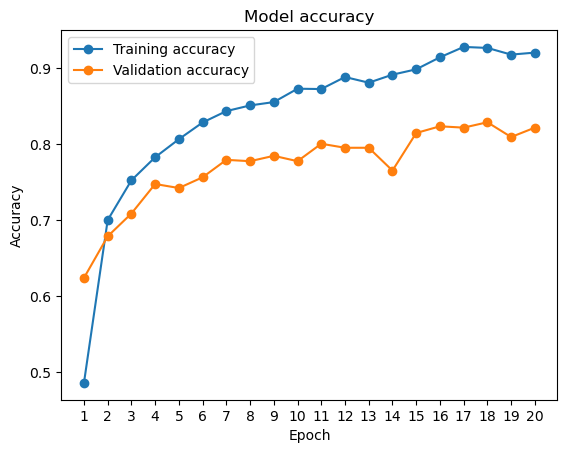

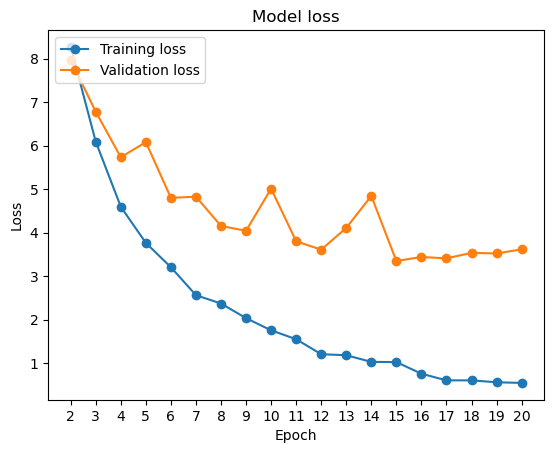

In [14]:
plot_history(history)

Model Getestet (Laden der Testdaten)

In [15]:
# Erstelle einen ImageDataGenerator für die Testdaten
test_datagen = ImageDataGenerator(rescale=1. / 255)  # Normalisiere die Bilder

# Lade die Testdaten
test_generator = test_datagen.flow_from_directory(
    f'{folder}/test',  
    target_size=target_size,  
    batch_size=batch_size,  
    class_mode='categorical',
    shuffle=False)  # Wichtig für die Evaluierung, um die Reihenfolge beizubehalten

Found 710 images belonging to 3 classes.


In [16]:
# Evaluierung des Modells mit den Testdaten
loss, accuracy = model.evaluate(test_generator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

23/23 [==============================] - 6s 261ms/step - loss: 0.9573 - accuracy: 0.5225
Test Loss: 0.9573474526405334
Test Accuracy: 0.5225352048873901


Klassifizieren von unbekanntem Bild

In [17]:
def classify_image(img_path, model, classes):
    # Bild anzeigen
    with Image.open(img_path) as img:
        display.display(img)
    # Bild laden und vorbereiten
    img = image.load_img(img_path, target_size=target_size)  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Vorhersage
    predictions = model.predict(img_array)
    print(predictions)

    # Ermittle die Klasse mit der höchsten Wahrscheinlichkeit
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_index]

    return predicted_class, predictions[0][predicted_class_index]

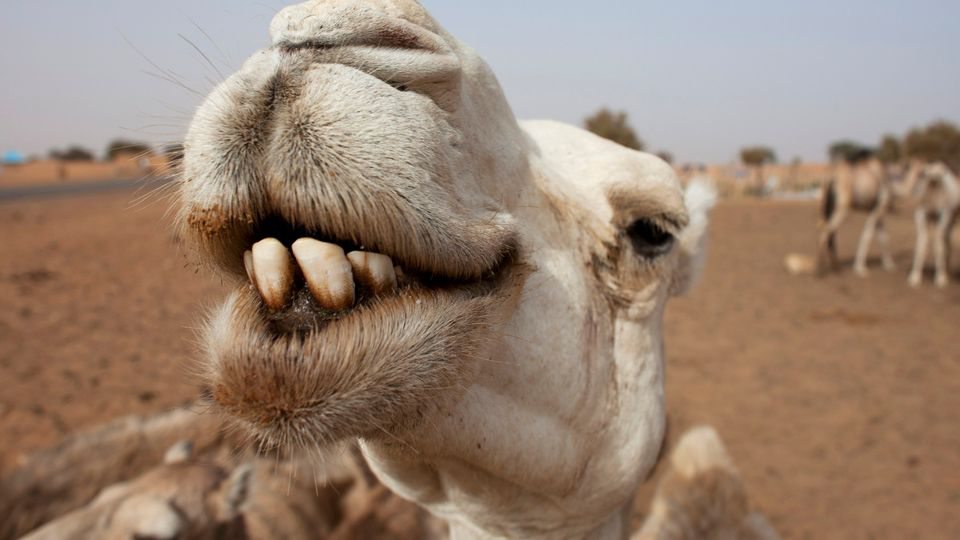

1/1 [==============================] - 1s 1s/step
[[1.3022917e-08 1.0000000e+00 1.4497513e-21]]
Das Modell hat das Bild klassifiziert als: ('Camel', 1.0)


In [18]:
# Klassifiziert das Bild
image_path = 'kamel.jpg'
predicted_class = classify_image(image_path, model, my_classes)
print(f'Das Modell hat das Bild klassifiziert als: {predicted_class}')
# model.save('alpacaCamelDog_baseModel')

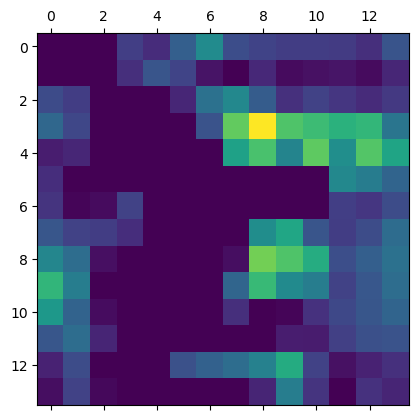

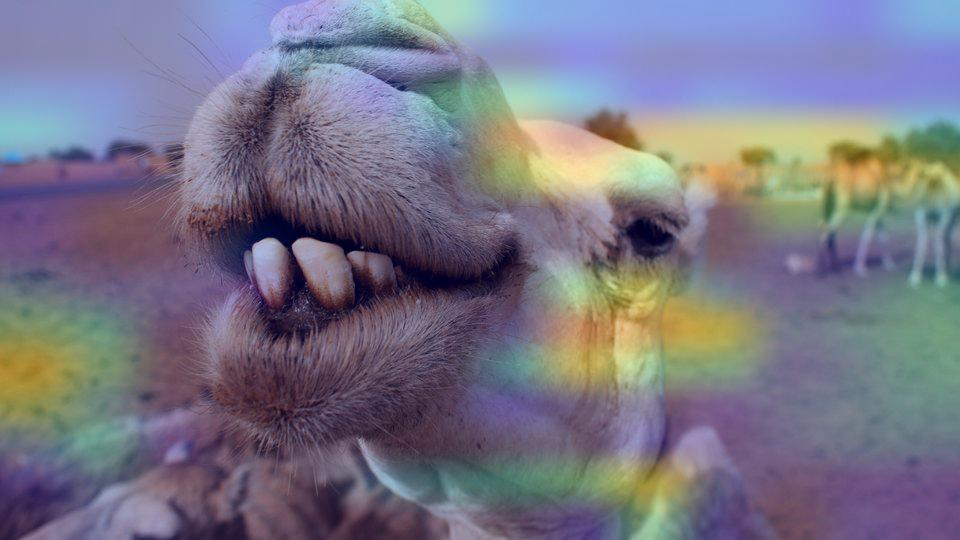

In [19]:
from IPython.display import Image, display

last_conv_layer_name = 'block5_conv4'
img_size = (224, 224)

# Bild für das Modell vorbereiten
img_array = preprocess_input(get_img_array(image_path, size=img_size))
# Heatmap generieren
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Heatmap anzeigen
plt.matshow(heatmap)
plt.show()

#Overlay
save_and_display_gradcam(image_path, heatmap)

### Task: Experiment data augmentation:

- Add data augmentation and train again, discuss results:
    - Random flip
    - Random contrast
    - Random translation

Diese Methode macht Random Contrast (Radim fip und Random translation wird von Image Generator bereitgestellt)

In [20]:
def custom_preprocessing_function(image):
    """
    Führt benutzerdefinierte Datenanreicherung wie Kontraständerung auf einem Bild aus.
    """
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image


# Erstelle einen ImageDataGenerator mit der benutzerdefinierten Funktion
datagen = ImageDataGenerator(
    # Zufällige horizontale Spiegelung
    horizontal_flip=True,
    # width_shift_range und height_shift_range für zufällige Translationen
    width_shift_range=0.2,  # horizontale Verschiebung
    height_shift_range=0.2,  # vertikale Verschiebung
    preprocessing_function=custom_preprocessing_function, 
    validation_split=0.2
)

Laden der Trainingsdaten

In [21]:
train_data_augmentation = datagen.flow_from_directory(
    f'{folder}/train/',  
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training'  # Trainingsdaten
)

validation_data_augmentation = datagen.flow_from_directory(
    f'{folder}/train/',  
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation'  # Validierungsdaten
)

Found 2272 images belonging to 3 classes.
Found 566 images belonging to 3 classes.


Training mit Data Augementation

In [22]:
augmentation_history = model.fit(
    train_data_augmentation,
    epochs=20,
    validation_data=validation_data_augmentation,
    # callbacks=[reduce_lr]
)

Epoch 1/20
71/71 [==============================] - 68s 959ms/step - loss: 3.4188 - accuracy: 0.7896 - val_loss: 4.0255 - val_accuracy: 0.7968
Epoch 2/20
71/71 [==============================] - 66s 937ms/step - loss: 3.4879 - accuracy: 0.8006 - val_loss: 3.1885 - val_accuracy: 0.7862
Epoch 3/20
71/71 [==============================] - 67s 941ms/step - loss: 2.5947 - accuracy: 0.8314 - val_loss: 3.4426 - val_accuracy: 0.8004
Epoch 4/20
71/71 [==============================] - 72s 1s/step - loss: 2.5975 - accuracy: 0.8363 - val_loss: 3.4943 - val_accuracy: 0.8163
Epoch 5/20
71/71 [==============================] - 69s 976ms/step - loss: 2.3352 - accuracy: 0.8336 - val_loss: 3.1374 - val_accuracy: 0.8198
Epoch 6/20
71/71 [==============================] - 70s 992ms/step - loss: 2.6375 - accuracy: 0.8297 - val_loss: 4.5218 - val_accuracy: 0.7880
Epoch 7/20
71/71 [==============================] - 72s 1s/step - loss: 2.4187 - accuracy: 0.8363 - val_loss: 2.9351 - val_accuracy: 0.8375
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


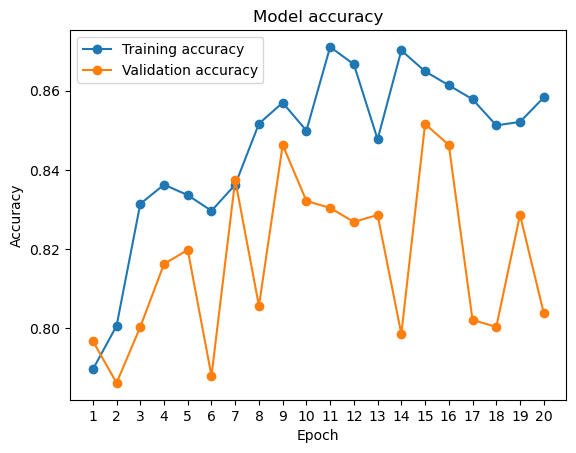

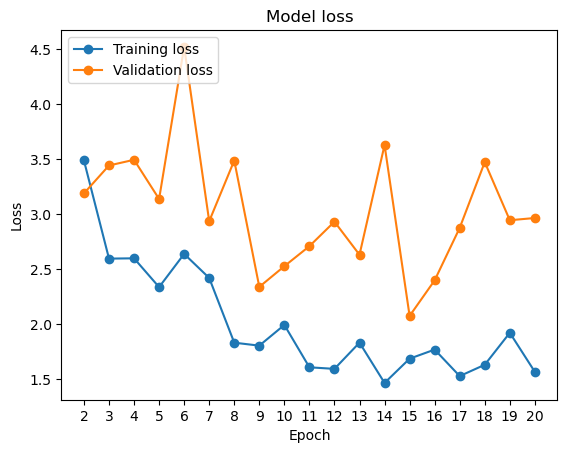

In [23]:
plot_history(augmentation_history)

Testen wie des Models mit Data augmentation

In [24]:
# Evaluierung des Modells mit den Testdaten
loss, accuracy = model.evaluate(test_generator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

23/23 [==============================] - 5s 186ms/step - loss: 0.9527 - accuracy: 0.5127
Test Loss: 0.9526501893997192
Test Accuracy: 0.5126760601997375


Klassifizieren von bild

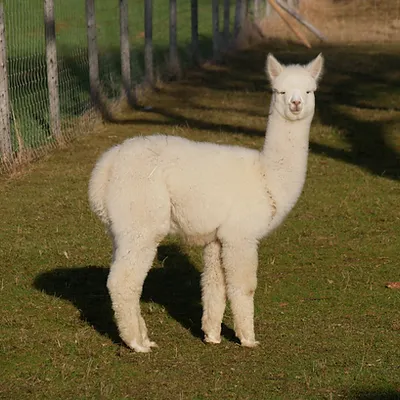

1/1 [==============================] - 0s 32ms/step
[[1.000000e+00 0.000000e+00 3.961583e-31]]
Das Modell hat das Bild klassifiziert als: ('Alpaca', 1.0)


In [26]:
from PIL import Image
import IPython.display as display

image_path = 'alpaka.webp'
predicted_class = classify_image(image_path, model, my_classes)
print(f'Das Modell hat das Bild klassifiziert als: {predicted_class}')
# model.save('alpacaCamelDog_baseModelAugmentation')

ActivationMap für Augmentation anzeigen

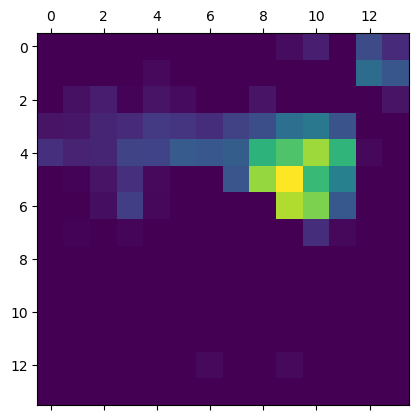

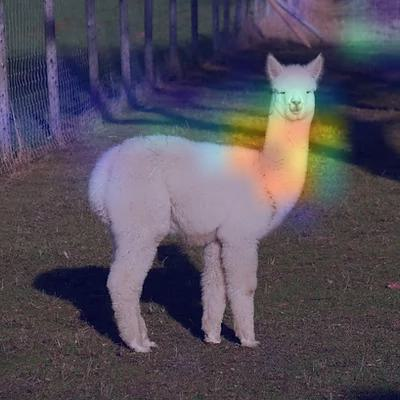

In [27]:
from IPython.display import Image, display

# Bild für das Modell vorbereiten
img_array = preprocess_input(get_img_array(image_path, size=img_size))
# Heatmap generieren
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Heatmap anzeigen
plt.matshow(heatmap)
plt.show()

#Overlay
save_and_display_gradcam(image_path, heatmap)

### Task: Experiment with architecture:

- Rebuild VGG19. After layer block4_conv4 (32, 32,512):
    - Add a naive inception layer (output filter size should be 512, each padding same, activations leaky relu)
    - Add conv layer (kernel 3x3, filters 512, padding valid, stride 2, activation relu)
    - Add conv layer (kernel 1x1, filters 640, padding valid, stride 1, activation relu)
    - Freeze conv2 layers and before
    - Test a few of your own images from the internet and show the activation maps (how did the neural net come to its conclusion)

Modell mit Layern wird definiert (Output = Modell-Innenlebven)

In [28]:
# Lade das VGG19-Modell bis zum block4_conv4
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv4').output)

# Naive Inception Layer
tower_1 = Conv2D(128, (1, 1), padding='same', activation=LeakyReLU(alpha=0.1))(model.output)
tower_2 = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.1))(model.output)
tower_3 = Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.1))(model.output)
tower_4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(model.output)
tower_4 = Conv2D(128, (1, 1), padding='same', activation=LeakyReLU(alpha=0.1))(tower_4)

# Kombiniere die Ausgänge der Türme
naive_inception_output = tf.keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=-1)

# Weitere Convolutional Layer
output = Conv2D(512, (3, 3), padding='valid', strides=2, activation='relu')(naive_inception_output)
output = Conv2D(640, (1, 1), padding='valid', strides=1, activation='relu')(output)

# Füge einen GlobalAveragePooling2D Layer hinzu wegen categorical_crossentropy als Loss Funktion 
output = GlobalMaxPooling2D()(output)
# zwei weitere Conv Layer, weil das Model ohne sie schlecht performiert (36-39% vs ca.50-60%)
output = Dense(44, activation='relu', kernel_regularizer=l2(l2_regularizer_rate))(output)
# output = Dropout(0.5)(output)  # Dropout-Rate von 50% --> hat auch nichts gebracht, um Overfitting zu vermeiden
output = Dense(22, activation='relu', kernel_regularizer=l2(l2_regularizer_rate))(output) 

# Füge einen Dense Layer als Output Layer mit einer softmax Aktivierung hinzu
predictions = Dense(num_classes, activation='softmax')(output)

# Erstelle das neue Modell
new_model = Model(inputs=model.input, outputs=predictions)

# Freeze conv2 layers and before
for layer in new_model.layers:
    layer.trainable = False
    if layer.name == 'block4_conv4':
        break

new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

Test ob die Layer richtig gefreezed sind

In [30]:
for layer in new_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
max_pooling2d True
conv2d True
conv2d_1 True
conv2d_2 True
conv2d_3 True
concatenate True
conv2d_4 True
conv2d_5 True
global_max_pooling2d_1 True
dense_1 True
dense_2 True
dense_3 True


Verändertes Model wird trainiert

In [31]:
new_model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

new_history = new_model.fit(
    train_data_augmentation,
    epochs=20,
    validation_data=validation_data_augmentation,
    # callbacks=[reduce_lr]
)

Epoch 1/20
71/71 [==============================] - 77s 1s/step - loss: 109.8095 - accuracy: 0.4313 - val_loss: 10.1209 - val_accuracy: 0.5883
Epoch 2/20
71/71 [==============================] - 77s 1s/step - loss: 7.0131 - accuracy: 0.6017 - val_loss: 8.0802 - val_accuracy: 0.5636
Epoch 3/20
71/71 [==============================] - 73s 1s/step - loss: 3.9967 - accuracy: 0.6712 - val_loss: 4.1549 - val_accuracy: 0.6272
Epoch 4/20
71/71 [==============================] - 69s 970ms/step - loss: 3.1239 - accuracy: 0.6739 - val_loss: 4.4276 - val_accuracy: 0.5583
Epoch 5/20
71/71 [==============================] - 70s 988ms/step - loss: 2.6250 - accuracy: 0.6633 - val_loss: 2.1982 - val_accuracy: 0.6802
Epoch 6/20
71/71 [==============================] - 71s 996ms/step - loss: 2.0103 - accuracy: 0.7069 - val_loss: 2.1440 - val_accuracy: 0.6413
Epoch 7/20
71/71 [==============================] - 71s 1s/step - loss: 1.9501 - accuracy: 0.6928 - val_loss: 2.3029 - val_accuracy: 0.6449
Epoch 8/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


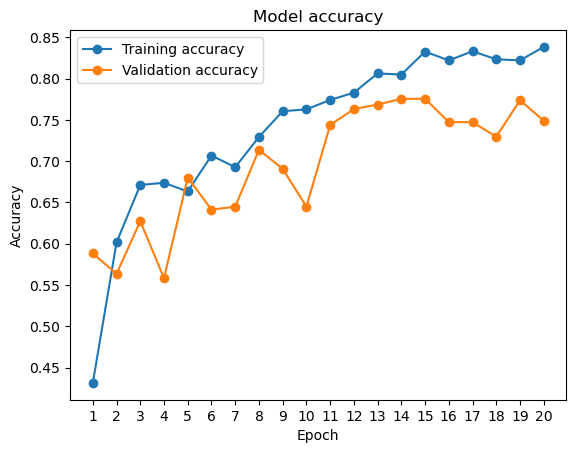

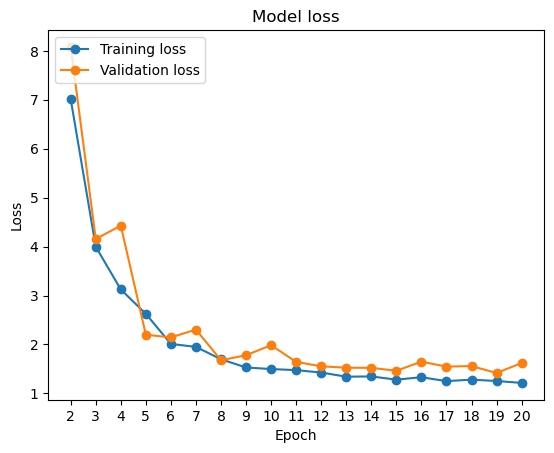

In [32]:
plot_history(new_history)

Modell evaluieren

In [33]:
# model testen
new_model.evaluate(test_generator)

23/23 [==============================] - 5s 207ms/step - loss: 1.8265 - accuracy: 0.4746


[1.8264728784561157, 0.4746478796005249]

Wieder mit einem random Bild getestet (ob kalssifizierung funktioniert)

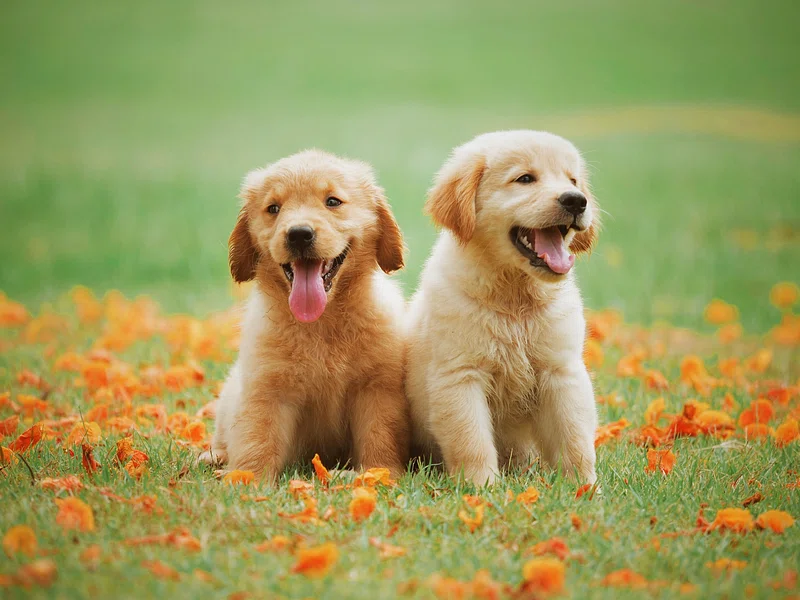

1/1 [==============================] - 1s 1s/step
[[9.3927860e-01 7.1534439e-04 6.0006008e-02]]
Das Modell hat das Bild klassifiziert als: ('Alpaca', 0.9392786)


In [34]:
from PIL import Image
import IPython.display as display

image_path = 'dog.webp'
predicted_class = classify_image(image_path, new_model, my_classes)
print(f'Das Modell hat das Bild klassifiziert als: {predicted_class}')
new_model.save('alpacaCamelDog_CustomModel')

Activation map

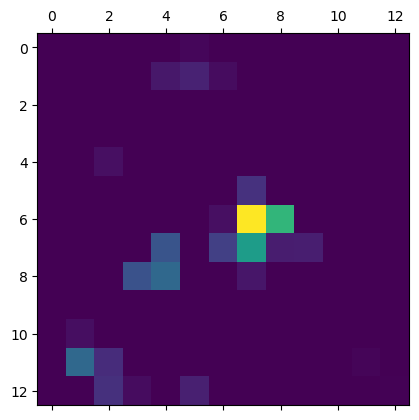

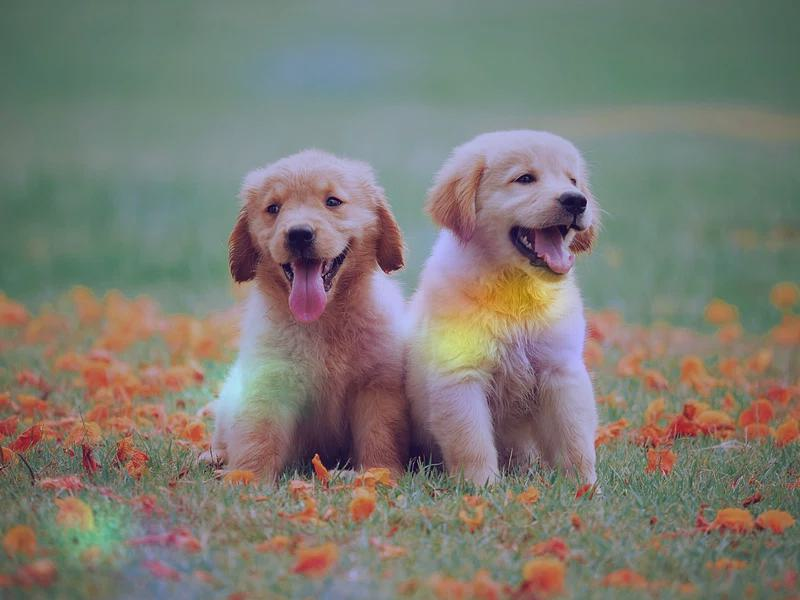

In [35]:
from IPython.display import Image, display

# Modell-Layer-Namen
last_conv_layer_name = 'conv2d_5'

# Bild für das Modell vorbereiten
img_array = preprocess_input(get_img_array(image_path, size=img_size))
# Heatmap generieren
heatmap = make_gradcam_heatmap(img_array, new_model, last_conv_layer_name)

# Heatmap anzeigen
plt.matshow(heatmap)
plt.show()

#Overlay
save_and_display_gradcam(image_path, heatmap)